In [1]:
!pip install tensorflow-text==2.0.0 --user

     |████████████████████████████████| 9.1 MB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 86.4 MB 25.4 MB/s eta 0:00:01     |███████████████████████         | 62.2 MB 14.3 MB/s eta 0:00:02     |███████████████████████▌        | 63.4 MB 14.3 MB/s eta 0:00:02     |█████████████████████████       | 67.4 MB 14.3 MB/s eta 0:00:02     |██████████████████████████      | 70.0 MB 14.3 MB/s eta 0:00:02     |██████████████████████████▍     | 71.3 MB 14.3 MB/s eta 0:00:02     |█████████████████████████████▋  | 80.0 MB 14.3 MB/s eta 0:00:01     |██████████████████████████████▍ | 82.0 MB 25.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 42.2 MB/s eta 0:00:01
     |████████████████████████████████| 449 kB 40.3 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 5.4 MB/s  eta 0:00:01
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7539 sha256=4ec22b676658e26cfe70e327bdc51cd4385c54c920019ed148f6d487f504d684
  Stored in directory: /root

In [53]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import tensorflow_hub as hub
import tensorflow_text
from tqdm import tqdm

In [4]:
df=pd.read_csv('../input/nlp-getting-started/train.csv')
test_df=pd.read_csv('../input/nlp-getting-started/test.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
df.drop(['keyword','location','id'],axis='columns',inplace=True)

Text(0.5, 1.0, 'target')

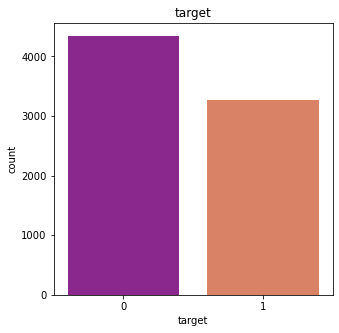

In [7]:
sns.countplot(df['target'], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.title('target')

In [8]:
df.shape

(7613, 2)

In [9]:
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


## Text Preprocessing

In [10]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
     "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited","ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [11]:
def text_cleaner(text):
    temp = text.lower()
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    temp = url_pattern.sub(r'', temp)
    html=re.compile(r'<[^>]+>')
    temp = html.sub(r'',temp)
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    temp = emoji_pattern.sub(r'', temp)
    
    table=str.maketrans('','',string.punctuation)
    temp = temp.translate(table)
    
    tem=[]
    for word in temp.split():
        if word in abbreviations.keys():
            tem.append(abbreviations[word])
        else:
            tem.append(word)
    temp=tem
    
    stop_words = set(stopwords.words('english'))
    le=WordNetLemmatizer()
    tokens = [le.lemmatize(word) for word in temp if not word in stop_words]
    
    long_words=[]
    for i in tokens:
        if len(i)>1:                                            
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [12]:
df['text'] = df['text'].apply(lambda text: text_cleaner(text))
df.head()

,text,target
0,deed reason earthquake may allah forgive,1
1,forest fire near la ronge sask canada,1
2,resident asked shelter place notified officer ...,1
3,13000 people receive wildfire evacuation order...,1
4,got sent photo ruby alaska smoke wildfire pour...,1


#### Drop empty texts

In [13]:
df.replace('', np.nan, inplace=True)
df.dropna(axis='rows',inplace=True)

In [14]:
def leng(text):
    return len(text.split())

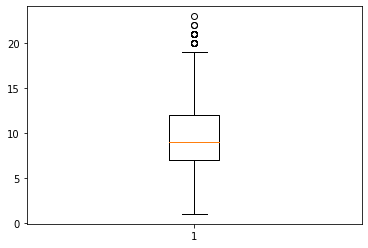

In [15]:
df['text_length']=df['text'].apply(lambda text: leng(text))
plt.boxplot(df['text_length'])
plt.show()

In [16]:
maximum = df['text_length'].max()

## Relabeling mislabeled tweets

In [17]:
df_mislabeled = df.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
index_mislabeled = df_mislabeled.index.tolist()

length = len(index_mislabeled)
print(length)

73


There are 73 texts that are mislabeled.

In [18]:
df_mistext_check_before = df[df['text'].isin(index_mislabeled)].sort_values(by = 'text')
df_mistext_check_before.head(10)

,text,target,text_length
3930,2pcs 18w cree led work light offroad lamp car ...,0,17
3917,2pcs 18w cree led work light offroad lamp car ...,0,17
3933,2pcs 18w cree led work light offroad lamp car ...,0,17
3924,2pcs 18w cree led work light offroad lamp car ...,1,17
5833,360wisenews china stock market crash gem rubble,1,7
5837,360wisenews china stock market crash gem rubble,0,7
5817,360wisenews china stock market crash gem rubble,0,7
5823,360wisenews china stock market crash gem rubble,1,7
5814,accionempresa chinaûªs stock market crash sum...,0,12
5813,accionempresa chinaûªs stock market crash sum...,1,12


In [19]:
majority_df = df_mistext_check_before.groupby(['text'])['target'].mean()#apply(lambda x: x.mode())

In [20]:
majority_df

text
2pcs 18w cree led work light offroad lamp car truck boat mining 4wd flood beam full reaû                     0.250000
360wisenews china stock market crash gem rubble                                                               0.500000
accionempresa chinaûªs stock market crash summer sparked interest bargain hunt gerenciatodos å¨              0.500000
allah describes piling wealth thinking would last forever description people hellfire surah humaza reflect    0.333333
angry woman openly accuses nema stealing relief material meant idp angry internally displaced wom             0.333333
                                                                                                                ...   
way move like full rainstorm im house card                                                                    0.500000
world annihilation self transformation alien attack exterminate human                                         0.500000
world fedex longer transport bioterror germ

We will relabel them according to mean of the labels of the same tweet.

In [21]:
def relabel(row, majority_index):
    ind = ''
    if row['text'] in majority_index:
        ind = row['text']
        if majority_df[ind] < 0.5:
            return 0
        else:
            return 1
    else:
        return row['target']


In [22]:
# df['target'] = df[df['text'].isin(majority_df.index.tolist())].apply(lambda row['target']: majority_df[row['text']]) 
df['target'] = df.apply( lambda row: relabel(row, majority_df.index), axis = 1)
# df['target']=df['target'].apply(lambda row : int(row))

In [23]:
df_mislabeled = df.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
index_mislabeled = df_mislabeled.index.tolist()

length = len(index_mislabeled)
print(length)

0


After relabeling, we can see that there are no mislabeled tweets.

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         7613 non-null   object
 1   target       7613 non-null   int64 
 2   text_length  7613 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 237.9+ KB


## Glove Vector Embeddings

In [25]:
x_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>') 
x_tokenizer.fit_on_texts(list(df['text']))

In [26]:
df['sequences']=x_tokenizer.texts_to_sequences(df['text'])

In [27]:
df['sequences'].iloc[0]

[4079, 456, 163, 70, 1431, 4080]

In [37]:
from sklearn.model_selection import train_test_split
x_train,x_valid,y_train,y_valid=train_test_split(df['sequences'],df['target'].values,test_size=0.2,shuffle=True) 

In [38]:
x_train   =   tf.keras.preprocessing.sequence.pad_sequences(x_train,maxlen=maximum, padding='post')
x_valid   =   tf.keras.preprocessing.sequence.pad_sequences(x_valid,maxlen=maximum, padding='post')

x_voc   =  len(x_tokenizer.word_index) + 1 

In [39]:
x_word_index = x_tokenizer.word_index

In [40]:
len(x_word_index)

16617

In [32]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

--2020-07-31 12:40:05--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  56.5MB/s    in 6.6s    

2020-07-31 12:40:12 (50.5 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [33]:
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((x_voc+1, 100));
for word, i in x_word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [34]:
embeddings_matrix.shape

(16619, 100)

In [41]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(x_voc+1, 100, input_length=maximum, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences = False)),
#     tf.keras.layers.LSTM(64,return_sequences = True),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.LSTM(32),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = False)),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
model.summary()

num_epochs = 20

history = model.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_valid, y_valid), verbose=2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 23, 100)           1661900   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 23, 100)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_4 (Dense)              (None, 20)                4020      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 1,826,741
Trainable params: 164,841
Non-trainable params: 1,661,900
_________________________________________________________________
Train on 6090 samples, validate on 1523 samples
Epoch 1/20
6090/6090 - 13s - loss: 0.5796 - accuracy: 0.

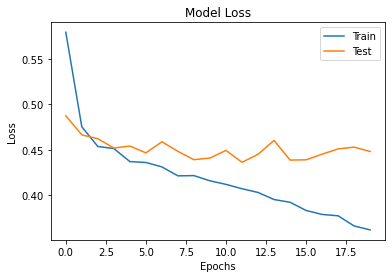

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

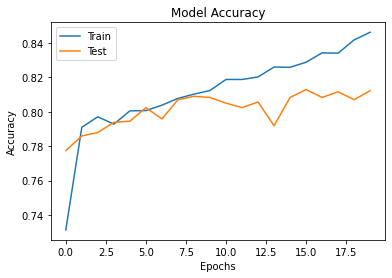

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.show()

In [44]:
test_df.drop(['location','id','keyword'],axis='columns',inplace=True)

In [45]:
test_df.head()

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


In [46]:
test_df['text'] = test_df['text'].apply(lambda text: text_cleaner(text))

In [47]:
test_df.head()

,text
0,happened terrible car crash
1,heard earthquake different city stay safe ever...
2,forest fire spot pond goose fleeing across str...
3,apocalypse lighting spokane wildfire
4,typhoon soudelor kill 28 china taiwan


In [48]:
test_seq = x_tokenizer.texts_to_sequences(test_df['text'])
test_seq = tf.keras.preprocessing.sequence.pad_sequences(test_seq,maxlen=maximum, padding='post')

In [49]:
preds=model.predict(test_seq)
preds=[int(round(x[0])) for x in preds]
samp=pd.read_csv("../input/nlp-getting-started/sample_submission.csv")
samp["target"]=preds
samp["target"].value_counts()

0    2126
1    1137
Name: target, dtype: int64

In [50]:
samp.to_csv("outputGlove.csv",index=False)

## Transformer Encoding + SVM

In [51]:
encoder=hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

In [54]:
X = []
for row in tqdm(df['text'].values):
  emb = encoder(row)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X.append(review_emb)

X = np.array(X)
Y = df.target.values

X_test = []
for row in tqdm(test_df.text.values):
  emb = encoder(row)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(review_emb)

X_test = np.array(X_test)

100%|██████████| 3263/3263 [02:35<00:00, 20.93it/s]


In [56]:
X_train,X_valid,y_train,y_test=train_test_split(X,Y,random_state =42,test_size=0.20)

In [57]:
from sklearn.svm import SVC
clf=SVC(kernel='rbf')

In [58]:
clf.fit(X_train,y_train)

SVC()

In [62]:
pred = clf.predict(X_valid)

In [63]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,pred)
cm

array([[791,  87],
       [155, 490]])

In [66]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,pred)

0.8411030860144452

In [67]:
preds=clf.predict(X_test)

In [68]:
samp=pd.read_csv("../input/nlp-getting-started/sample_submission.csv")
samp["target"]=preds
samp["target"].value_counts()

0    2053
1    1210
Name: target, dtype: int64

In [69]:
samp.to_csv("outputTransformers.csv",index=False)